### Import Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os
import sys
import time

### Hardware Accelerator Check

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Preparation

In [4]:
# defining data transforms for train and test datasets

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2615)),
])


In [5]:
# importing CIFAR10 train and test datasets

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# number of data points in train dataset

trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2434, 0.2615))
           )

In [7]:
# number of data points in test dataset

testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2434, 0.2615))
           )

In [8]:
# creating data loaders for train and test datasets

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


In [9]:
# The different classes in CIFAR10 dataset are

trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

### ResNet18 NN Basic Block

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### ResNet18 Architecture

In [12]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.softmax = nn.Softmax()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.softmax(out)
        F.sof
        return out

### Initialize the Model

In [13]:
net = ResNet18(BasicBlock, [2, 2, 2, 2])

In [14]:
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print("Device is set to CUDA")

Device is set to CUDA


In [15]:
best_acc = 0  # best test accuracy
start_epoch = 0 # start from epoch 0 or last checkpoint epoch

### Define Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### Training

In [17]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    save_loss['train'].append(train_loss/(batch_idx+1))
    save_acc['train'].append(100.*correct/total)

### Testing

In [18]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        save_loss['test'].append(test_loss/(batch_idx+1))
        save_acc['test'].append(100.*correct/total)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


### Train and Evaluate

In [19]:
for epoch in range(start_epoch, 100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0


<ipython-input-12-c0bf8ff740cd>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)


Train Loss: 6.198 | Train Acc: 13.110% (6555/50000)
Test Loss: 6.082 | Test Acc: 29.950% (2995/10000)
Saving..

Epoch: 1
Train Loss: 5.991 | Train Acc: 35.602% (17801/50000)
Test Loss: 5.884 | Test Acc: 41.760% (4176/10000)
Saving..

Epoch: 2
Train Loss: 5.830 | Train Acc: 46.224% (23112/50000)
Test Loss: 5.848 | Test Acc: 42.820% (4282/10000)
Saving..

Epoch: 3
Train Loss: 5.735 | Train Acc: 53.528% (26764/50000)
Test Loss: 5.690 | Test Acc: 57.370% (5737/10000)
Saving..

Epoch: 4
Train Loss: 5.680 | Train Acc: 58.084% (29042/50000)
Test Loss: 5.654 | Test Acc: 60.070% (6007/10000)
Saving..

Epoch: 5
Train Loss: 5.634 | Train Acc: 62.448% (31224/50000)
Test Loss: 5.650 | Test Acc: 60.360% (6036/10000)
Saving..

Epoch: 6
Train Loss: 5.606 | Train Acc: 64.918% (32459/50000)
Test Loss: 5.642 | Test Acc: 60.880% (6088/10000)
Saving..

Epoch: 7
Train Loss: 5.579 | Train Acc: 67.564% (33782/50000)
Test Loss: 5.622 | Test Acc: 63.080% (6308/10000)
Saving..

Epoch: 8
Train Loss: 5.554 | Train

Text(0.5, 1.0, 'Train Accuracy vs Epoch')

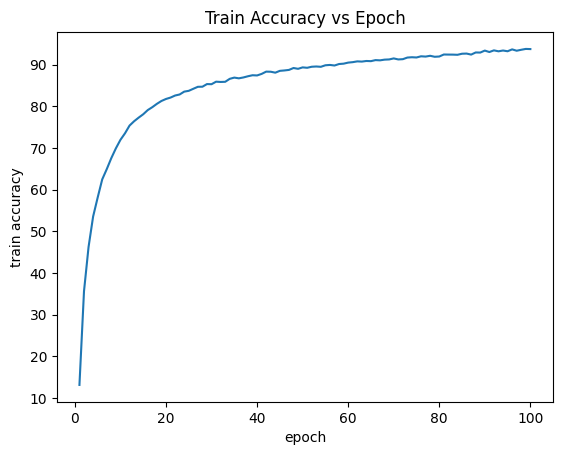

In [20]:
plt.plot(range(1,101), save_acc['train'])
plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.title("Train Accuracy vs Epoch")

Text(0.5, 1.0, 'Test Accuracy vs Epoch')

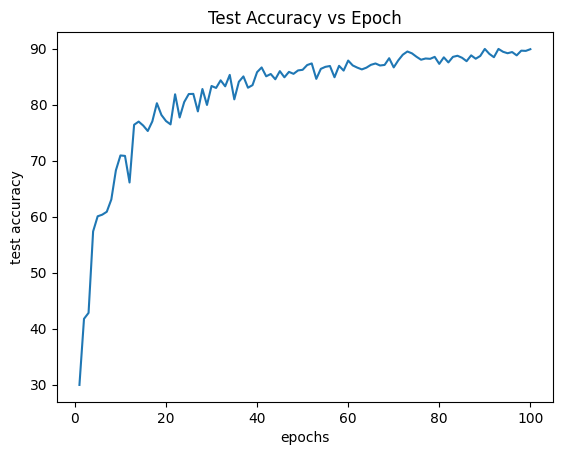

In [21]:
plt.plot(range(1,101), save_acc['test'])
plt.xlabel("epochs")
plt.ylabel("test accuracy")
plt.title("Test Accuracy vs Epoch")

Text(0.5, 1.0, 'Train Loss vs Epoch')

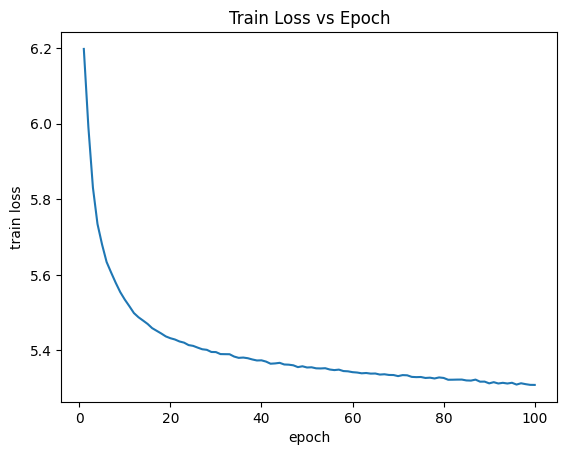

In [22]:
plt.plot(range(1,101), save_loss['train'])
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title("Train Loss vs Epoch")

Text(0.5, 1.0, 'Test Loss vs Epoch')

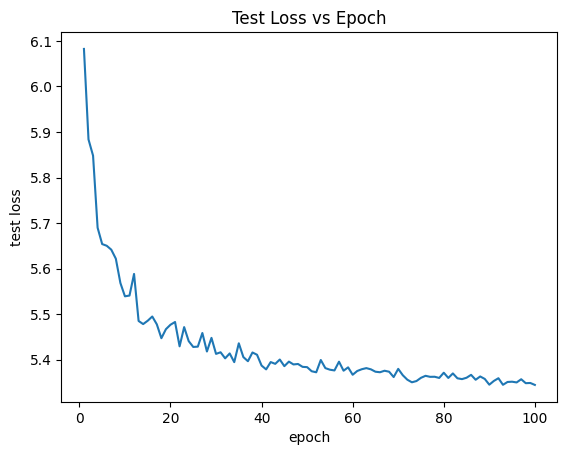

In [23]:
plt.plot(range(1,101), save_loss['test'])
plt.xlabel("epoch")
plt.ylabel("test loss")
plt.title("Test Loss vs Epoch")